In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
conf = SparkConf()
#set config
conf = conf.setAppName("ml_sparkSession") \
           .setMaster('local') \
           .set("spark.executor.memory", "2g") \
           .set("spark.executor.cores", "4") \
           .set("spark.sql.shuffle.partitions", "8") \
           .set("spark.executor.instances", "1") 
#create Spark Session
spark = SparkSession.builder.config(conf = conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/26 01:20:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
#read data
silver_artist = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_artist")
silver_album = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_album")
silver_track = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_track")
silver_track_feature = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_track_feature")
#rename columns
silver_artist = silver_artist.withColumnRenamed('id', 'artist_id') \
                            .withColumnRenamed('name', 'artist_name')
#drop unnecessary columns and rename columns 
silver_album = silver_album.drop('artist', 'label', 'popularity', 'copyrights', 'url', 'link_image') \
                        .withColumnRenamed('id', 'album_id') \
                        .withColumnRenamed('name', 'album_name') \
                        .withColumnRenamed('type', 'album_type')  \
                        .withColumnRenamed('popularity', 'album_popularity')
#joining table and creating summary album table
summary_album_table = silver_artist.join(silver_album, on = 'artist_id', how = 'inner')
summary_album_table = summary_album_table.select('artist_id','artist_name','album_id','album_name',
                        'genres','followers','popularity','link_image','url','album_type',
                        'total_tracks','release_date','release_date_precision')

#joining table and creating summary track feature table
silver_track = silver_track.select('album_id', 'album_name', 'id', 'name', 'preview')
summary_feature_table = silver_track.join(silver_track_feature, on = 'id', how = 'left')
summary_feature_table = summary_feature_table.withColumnRenamed('id', 'track_id')

summary_table = summary_album_table.join(summary_feature_table, on = 'album_id', how = 'inner')
summary_table.cache()

DataFrame[album_id: string, artist_id: string, artist_name: string, album_name: string, genres: string, followers: int, popularity: int, link_image: string, url: string, album_type: string, total_tracks: int, release_date: date, release_date_precision: string, track_id: string, album_name: string, name: string, preview: string, danceability: float, energy: float, key: int, loudness: float, mode: int, speechiness: float, acousticness: float, instrumentalness: float, liveness: float, valence: float, tempo: float, time_signature: int, Execution_date: date]

In [12]:
# summary_album_table.show()
# summary_feature_table.show()
summary_table.show()

+--------------------+--------------------+---------------+--------------------+-------+---------+----------+--------------------+--------------------+----------+------------+------------+----------------------+--------------------+--------------------+--------------------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+--------------+
|            album_id|           artist_id|    artist_name|          album_name| genres|followers|popularity|          link_image|                 url|album_type|total_tracks|release_date|release_date_precision|            track_id|          album_name|                name|             preview|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|Execution_date|
+--------------------+--------------------+---------------+--------------------+-------+---------+----------+--------------------+--------

In [13]:
print(summary_table.columns)

['album_id', 'artist_id', 'artist_name', 'album_name', 'genres', 'followers', 'popularity', 'link_image', 'url', 'album_type', 'total_tracks', 'release_date', 'release_date_precision', 'track_id', 'album_name', 'name', 'preview', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'Execution_date']


We initially drop the unwanted columns from dataFrame

In [14]:
summary_table = summary_table.drop('album_name', 'album_type', 'release_date_precision', 'time_signature')

2.303.371 size of summary table

### Exploratory Data Analysis (EDA)

- Check artist having most followers on the world

In [15]:
from pyspark.sql.functions import max

# Find the artist having most followers 
max_fl = summary_table.agg(max("followers").alias("max_fl")).collect()[0]["max_fl"]
print(max_fl)

123616624


In [16]:
from pyspark.sql.functions import col
best_playlist = summary_table.filter(col("followers") == max_fl).select("artist_name").distinct()

best_playlist.show(truncate= False)

best_playlist_list = best_playlist.rdd.flatMap(lambda x: x).collect()
print("Best Playlist:\n", best_playlist_list)

+------------+
|artist_name |
+------------+
|Arijit Singh|
+------------+



Best Playlist:
 ['Arijit Singh']


- Check which artists are featured most across all playlist for top 10 artists

/tmp/ipykernel_310/2540731308.py:18: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y = names, x = values, palette= 'pastel')


Text(0.5, 0, 'Total songs across playlists')

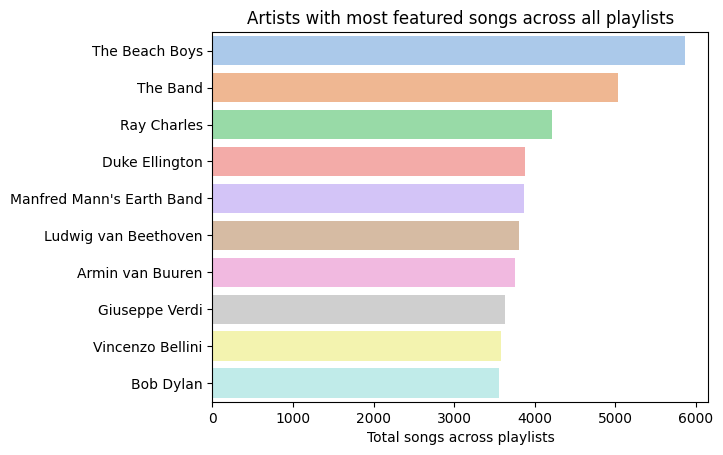

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt 

# Step 1: Group by artist_name and count the apparence
artist_counts = summary_table.groupBy("artist_name").count()

# Step 2: Sort descending by the apparence
sorted_artist_counts = artist_counts.orderBy("count", ascending = False)

# Step 3: Convert to pandas to plot data
artist_counts_pd = sorted_artist_counts.limit(10).toPandas()

# Step 4: Take the values and name of artists
values = artist_counts_pd['count'].tolist()
names = artist_counts_pd['artist_name'].tolist()

# Step 5: Plot data with seaborn
ax = sns.barplot(y = names, x = values, palette= 'pastel')
ax.set_title('Artists with most featured songs across all playlists')
ax.set_xlabel('Total songs across playlists')

- Top 10 artists and music genres are most popular in the world

In [18]:
from pyspark.sql import functions as F

# Group by artist_name and calculate mean of followers 
artist_fl = summary_table.groupBy('artist_name').agg(F.mean('followers').alias('followers'))

# Sort by followers in descending order
sorted_artist_fl = artist_fl.orderBy('followers', ascending = False).limit(10)

sorted_artist_fl.show()

+-------------+------------+
|  artist_name|   followers|
+-------------+------------+
| Arijit Singh|1.23616624E8|
| Taylor Swift|1.22781005E8|
|   Ed Sheeran|1.16283003E8|
|Billie Eilish|1.00208733E8|
|Ariana Grande|1.00144929E8|
|        Drake| 9.2294533E7|
|   The Weeknd| 9.2004576E7|
|       Eminem| 9.0916937E7|
|    Bad Bunny|  8.600057E7|
|Justin Bieber| 7.7680104E7|
+-------------+------------+



In [19]:
# Group by genres and calculate mean of popularity
popular_genres = summary_table.groupBy('genres').agg(F.mean('popularity').alias('avg_popularity'))

# Sort by popularity in descending order
sorted_popular_genres = popular_genres.orderBy('avg_popularity', ascending = False).limit(10)

sorted_popular_genres.show()

+--------------------+-----------------+
|              genres|   avg_popularity|
+--------------------+-----------------+
|       el paso indie|             85.0|
|         ambient pop|             85.0|
|            big room|83.72384428223845|
|             r&drill|             83.0|
|south carolina hi...|             83.0|
| musica tocantinense|82.83552631578948|
|      pittsburgh rap|  82.502722323049|
|           dutch edm|82.25934579439253|
|   nashville hip hop|             82.0|
|       barbadian pop|81.27737226277372|
+--------------------+-----------------+



### Data Preprocessing

1. Check null values in each columns

In [20]:
from pyspark.sql import functions as F
# Function to check null values in each columns

def count_nulls(df):
    # Calculate null values in each columns
    null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
    
    # Show results
    null_counts.show()

In [21]:
print(count_nulls(summary_table))

+--------+---------+-----------+------+---------+----------+----------+---+------------+------------+--------+----+-------+------------+------+-----+--------+-----+-----------+------------+----------------+--------+-------+-----+--------------+
|album_id|artist_id|artist_name|genres|followers|popularity|link_image|url|total_tracks|release_date|track_id|name|preview|danceability|energy|  key|loudness| mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|Execution_date|
+--------+---------+-----------+------+---------+----------+----------+---+------------+------------+--------+----+-------+------------+------+-----+--------+-----+-----------+------------+----------------+--------+-------+-----+--------------+
|       0|        0|          0| 87067|        0|         0|         0|  0|           0|      134898|       0|  52| 523827|       81869| 81869|81869|   81869|81869|      81869|       81869|           81869|   81869|  81869|81869|         76720|
+--------+---------+

2. Drop those columns not affect to build the model

In [22]:
summary_table = summary_table.drop('release_date', 'total_tracks', 'mode', 'track_id')

In [23]:
tracks = summary_table.drop('preview')

In [24]:
print(count_nulls(tracks))

+--------+---------+-----------+------+---------+----------+----------+---+----+------------+------+-----+--------+-----------+------------+----------------+--------+-------+-----+--------------+
|album_id|artist_id|artist_name|genres|followers|popularity|link_image|url|name|danceability|energy|  key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo|Execution_date|
+--------+---------+-----------+------+---------+----------+----------+---+----+------------+------+-----+--------+-----------+------------+----------------+--------+-------+-----+--------------+
|       0|        0|          0| 87067|        0|         0|         0|  0|  52|       81869| 81869|81869|   81869|      81869|       81869|           81869|   81869|  81869|81869|         76720|
+--------+---------+-----------+------+---------+----------+----------+---+----+------------+------+-----+--------+-----------+------------+----------------+--------+-------+-----+--------------+

None


In [25]:
# Function to return shape of table
def shape(df):
    num_rows = df.count()
    nums_cols = len(df.columns)
    
    return (num_rows, nums_cols)

In [26]:
print(shape(tracks))

(2390407, 20)


Vì những cột name là tên bài hát không có nên ta sẽ bỏ những hàng không có tên bài hát đó đi vì nếu không có tên bài hát thì không thể nào recommend cho user

In [70]:
tracks = tracks.dropna(subset = ['name'])
print(shape(tracks))

(2390355, 25)


Vì những cột features như là danceability, energy, acousticness, valence, tempo là những features quan trọng cho việc phân loại theo cảm xúc nên nếu là null values ta sẽ loại bỏ hết những hàng đó

In [27]:
# List of columns need to be dropped
cols_to_drop = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Drop those columns above
tracks = tracks.dropna(subset = cols_to_drop)
print(shape(tracks))

(2308538, 20)


In [28]:
print(count_nulls(tracks))

+--------+---------+-----------+------+---------+----------+----------+---+----+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+--------------+
|album_id|artist_id|artist_name|genres|followers|popularity|link_image|url|name|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo|Execution_date|
+--------+---------+-----------+------+---------+----------+----------+---+----+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+--------------+
|       0|        0|          0| 81748|        0|         0|         0|  0|  52|           0|     0|  0|       0|          0|           0|               0|       0|      0|    0|             0|
+--------+---------+-----------+------+---------+----------+----------+---+----+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+--------------+

None


### Build Recommendation System

##### 1/ Recommend songs by name of song

1. Transform music genres to vectorized metrics

Chúng ta sẽ xử dụng kĩ thuật được gọi là Count Vectorizer để chuyển đổi các thể loại nhạc (genres) thành dạng vector số. Ví dụ như 'rock pop' có thể được mã hóa thành vector [1, 1, 0, ...] trong đó mỗi phần tử biểu thị sự hiện diện hoặc tần suất của 1 từ trong từ

We will use a technique called Count Vectorizer to convert music genres into a vector of numbers. For example 'rock pop' can be encoded as a vector [1, 1, 0, ...] where each element represents the presence or frequency of a word in the word.

In [29]:
tracks_for_cbf = tracks
print(f"Number of unique genres: {tracks_for_cbf.select('genres').distinct().count()}")

Number of unique genres: 2877


- Build CounterVectorizer to convert music genres

In [30]:
# Split the 'genres' column into an array of words
unique_genres = tracks_for_cbf.select(
    F.split(tracks_for_cbf['genres'], ' ').alias('genres_array')
)

# Show the resulting DataFrame
unique_genres.show(truncate=False)

+------------+
|genres_array|
+------------+
|[otacore]   |
|[otacore]   |
|[otacore]   |
|[otacore]   |
|[otacore]   |
|[otacore]   |
|[otacore]   |
|[otacore]   |
|[otacore]   |
|[otacore]   |
|[otacore]   |
|[otacore]   |
|[europop]   |
|[europop]   |
|[europop]   |
|[europop]   |
|[europop]   |
|[europop]   |
|[europop]   |
|[europop]   |
+------------+
only showing top 20 rows



##### 2/ Recommend songs by mood and genres

1. Using Standard Scaling to scale

In [31]:
tracks_cleaned_mood = tracks.drop('album_id')

- Function to normalize by using standard scailing method

We print Schema to determine which columns will be used to caculate Z-score.

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev

def z_score(df):
    
    # Identify numerical columns
    num_cols = [col_name for col_name, dtype in df.dtypes if dtype in ['int', 'float', 'double']]

    # Create a list to store transformations
    z_score_cols = []

    for col_name in num_cols:
        # Compute mean and standard deviation for the column
        mean_val = df.select(mean(col(col_name))).first()[0]
        stddev_val = df.select(stddev(col(col_name))).first()[0]

        # Apply Z-score formula
        z_score_cols.append(((col(col_name) - mean_val) / stddev_val).alias(col_name))

    # Add non-numerical columns to the result
    other_cols = [col(c) for c in df.columns if c not in num_cols]
    result_cols = other_cols + z_score_cols

    # Return the updated DataFrame
    z_score_df = df.select(*result_cols)
    return z_score_df

z_score_df = z_score(tracks_cleaned_mood)
z_score_df.cache()

DataFrame[artist_id: string, artist_name: string, genres: string, link_image: string, url: string, name: string, Execution_date: date, followers: double, popularity: double, danceability: double, energy: double, key: double, loudness: double, speechiness: double, acousticness: double, instrumentalness: double, liveness: double, valence: double, tempo: double]

In [37]:
z_score_df.show()

+--------------------+---------------+-------+--------------------+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|           artist_id|    artist_name| genres|          link_image|                 url|                name|Execution_date|           followers|          popularity|        danceability|              energy|                 key|           loudness|         speechiness|        acousticness|    instrumentalness|            liveness|             valence|               tempo|
+--------------------+---------------+-------+--------------------+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------

2. Using K-means algorithm to catgorize moods based on those important features

In [38]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import seaborn as sns

# Select relevant features
features_cols = ['valence', 'energy', 'danceability', 'acousticness', 'tempo']

# Assemble the features into a single vector column
vector_assembler = VectorAssembler(inputCols=features_cols, outputCol="features")
features_df = vector_assembler.transform(z_score_df)

# Apply KMeans with 3 clusters
kmeans = KMeans(k=3, seed=42, featuresCol="features", predictionCol="mood_score")
kmeans_model = kmeans.fit(features_df)

# Get cluster centers
cluster_centers = kmeans_model.clusterCenters()
cluster_features_list = [center.tolist() for center in cluster_centers]

# Create DataFrame with the cluster centers
cluster_features = spark.createDataFrame(cluster_features_list, schema=features_cols)
cluster_features.show()

# You can see the cluster features df:
# 1. with high valence, energy, and danceability -> maybe "Happy"
# 2. with low valence, energy, danceability but high acouticness -> maybe "Sad"
# 3. Remaining features -> will be "Neutral"

+-------------------+-------------------+--------------------+--------------------+--------------------+
|            valence|             energy|        danceability|        acousticness|               tempo|
+-------------------+-------------------+--------------------+--------------------+--------------------+
|-0.4647476930150049| 0.5711225200383706|-0.44828319026451646| -0.6918466041446091| 0.45197563426387904|
|-0.7960475734154833| -1.241016370280207| -0.7216002514413331|  1.2687830390244794| -0.4262177571749379|
| 0.8131388015056976|0.33963378489669405|  0.7564316599307263|-0.26991526589036374|-0.06659540845027619|
+-------------------+-------------------+--------------------+--------------------+--------------------+



In [ ]:
predictions_pd = predictions_with_mood.sample(fraction = 0.01, seed = 42)
predictions_pd.persist()

DataFrame[artist_id: string, artist_name: string, genres: string, link_image: string, url: string, name: string, followers: double, popularity: double, danceability: double, energy: double, key: double, loudness: double, speechiness: double, acousticness: double, instrumentalness: double, liveness: double, valence: double, tempo: double, features: vector, mood_score: int, mood: string]

24/11/25 10:04:49 WARN MemoryStore: Not enough space to cache rdd_2291_1 in memory! (computed 68.3 MiB so far)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


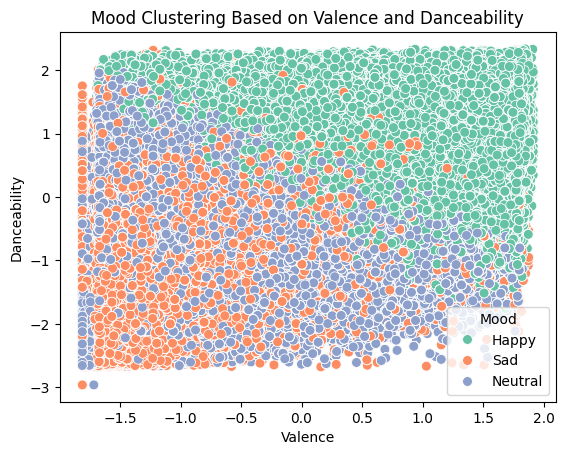

In [38]:

# Convert to Pandas for visualization
predictions_pd = predictions_with_mood.select("valence", "danceability", "mood").toPandas()

# Plot using Matplotlib
sns.scatterplot(data=predictions_pd, x="valence", y="danceability", hue="mood", palette="Set2", s=50)
plt.title("Mood Clustering Based on Valence and Danceability")
plt.xlabel("Valence")
plt.ylabel("Danceability")
plt.legend(title="Mood")
plt.show()